# Imports

In [1]:
!pip install torchmetrics matplotlib seaborn scikit-learn

  Using cached torchmetrics-1.3.2-py3-none-any.whl.metadata (19 kB)
  Using cached matplotlib-3.8.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.8 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached scikit_learn-1.4.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached lightning_utilities-0.11.2-py3-none-any.whl.metadata (4.7 kB)
  Using cached contourpy-1.2.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.8 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.51.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (159 kB)
  Using cached kiwisolver-1.4.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.4 kB)
  Using cached pyparsing-3.1.2-py3-none-any.whl.metadata (5.1 kB)
  Using cached pandas-2.2.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (19 kB)
  Using cac

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchmetrics

from torch.utils.data import Dataset ,DataLoader, WeightedRandomSampler
from torch.utils.data.dataset import Subset
from torch.utils.data import random_split
from torchvision import transforms
from PIL import Image

import os
import numpy as np
import json
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score

import seaborn as sns

# Dataset Class Definition for Non-Series Dataset

In this section, we define a custom dataset class `AlzheimerDataset` for handling the Alzheimer's MRI images dataset. Each image in this dataset is treated as an individual sample. This class is crucial for loading the images and their corresponding labels efficiently during the training and evaluation of our deep learning models. It allows us to apply transformations to the dataset images and prepare them for input into the neural network.

### Data Augmentation and DataLoader Preparation

In this section, we initialize the dataset and then apply data augmentation techniques to increase the diversity of our dataset, which can lead to better model generalization. After initializing the Alzheimer's dataset class, we split the dataset into training, validation, and test sets. To address the issue of class imbalance, we calculate class weights and utilize these weights to create a weighted sampler for the training data. Finally, we prepare DataLoader objects for each subset of the dataset to facilitate efficient data loading during the model training and evaluation phases.

To effectively handle class imbalance, we employ a weight rebalancing strategy that ensures less frequent classes are given more importance during training. This is accomplished through the following steps:

1. **Calculate Class Sample Counts**: We compute the number of samples for each class in the dataset. This count helps in identifying the extent of imbalance and determining the appropriate weight that each class should receive.

2. **Compute Class Weights**: For each class, the weight is calculated as the inverse of its sample count. This method assigns higher weights to less frequent classes, thus amplifying their presence during the training process.

3. **Assign Sample Weights**: Each sample in the dataset is then assigned a weight corresponding to its class weight. This results in a weighted distribution where the significance of each sample is adjusted according to its weight.

4. **Weighted Random Sampler**: In the training DataLoader, a WeightedRandomSampler is used with these sample weights. This sampler ensures that data batches are selected in a manner that reflects the assigned weights, providing more representation to underrepresented classes and mitigating the effects of class imbalance.

By applying these steps, we ensure that the training process accounts for all classes equitably, preventing the model from biasing towards the majority classes and thereby achieving a more balanced and accurate prediction across all classes.


In [3]:
class AlzheimerDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the image categories.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        categories = ['Mild Dementia', 'Moderate Dementia', 'Non Demented', 'Very mild Dementia']
        label_mapping = {category: idx for idx, category in enumerate(categories)}

        for category in categories:
            category_path = os.path.join(root_dir, category)
            for img_name in os.listdir(category_path):
                self.image_paths.append(os.path.join(category_path, img_name))
                self.labels.append(label_mapping[category])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('L')
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        label_tensor = torch.tensor(label, dtype=torch.long)
        return image, label_tensor

# Define transformations
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

val_test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Initialize the full dataset without transforms
full_dataset = AlzheimerDataset(root_dir='Data')

# Stratify split the dataset
np_labels = np.array(full_dataset.labels)
train_idx, val_test_idx = train_test_split(np.arange(len(np_labels)), test_size=0.3, stratify=np_labels, random_state=42)
val_idx, test_idx = train_test_split(val_test_idx, test_size=0.5, stratify=np_labels[val_test_idx], random_state=42)

# Create and transform subsets
train_dataset = Subset(AlzheimerDataset(root_dir='Data', transform=train_transforms), train_idx)
val_dataset = Subset(AlzheimerDataset(root_dir='Data', transform=val_test_transforms), val_idx)
test_dataset = Subset(AlzheimerDataset(root_dir='Data', transform=val_test_transforms), test_idx)

# Calculate and apply class weights
class_weights = [1.0 / np.sum(np_labels == i) for i in range(4)]
weights = torch.DoubleTensor([class_weights[label] for label in np_labels[train_idx]])
train_sampler = WeightedRandomSampler(weights, len(weights))

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, sampler=train_sampler, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

# Defining a Common Training Function for All Models

In this section, we define a universal training function that can be applied to all models since they share common inputs and outputs. This function will handle the model training and validation processes, including features like saving model checkpoints, tracking training and validation metrics, and handling interruptions gracefully to save the current training state. The use of a common training function streamlines the training process across different models, ensuring consistency and reducing code redundancy. This approach not only facilitates the management of different neural network training processes but also ensures that model evaluation is standardized and comparable across different model architectures.


In [4]:
def save_performance_metrics(performance_data, model_dir, filename):
    """
    Saves performance metrics to a JSON file.
    """
    filepath = os.path.join(model_dir, filename)
    with open(filepath, 'w') as file:
        json.dump(performance_data, file)
    print(f"Metrics saved to {filepath}")

def save_model_checkpoint(model, model_dir, filename):
    """
    Saves the model checkpoint to a file.
    """
    filepath = os.path.join(model_dir, filename)
    torch.save(model.state_dict(), filepath)
    print(f"Model saved to {filepath}")

def handle_keyboard_interrupt(model, model_dir, performance_data, last_epoch, epoch,adv=False):
    """
    Handles keyboard interrupt by saving the current model state and performance metrics.
    """
    model_filename = 'interrupted.pth' if not adv else 'adv_interrupted.pth'
    performance_filename = f'interrupted_performance_{last_epoch+1}_{epoch+1}.json'
    save_model_checkpoint(model, model_dir, model_filename)
    save_performance_metrics(performance_data, model_dir, performance_filename)

In [5]:
def train_model(model, train_loader, val_loader, device, model_checkpoint_path, model_name, epochs=5, load_pretrained=False, last_epoch=-1):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    best_val_f1score = 0
    best_val_loss = float('inf')

    train_loss_history = []
    train_accuracy_history = []
    val_loss_history = []
    val_accuracy_history = []
    val_f1score_history = []

    # Setup metrics
    val_f1_score = torchmetrics.F1Score(num_classes=4, average='macro', task='multiclass').to(device)
    val_accuracy = torchmetrics.Accuracy(num_classes=4, task='multiclass').to(device)


    model_save_dir = os.path.join(model_checkpoint_path, model_name)
    os.makedirs(model_save_dir, exist_ok=True)

    if load_pretrained and last_epoch >= 0:
        checkpoint_path = os.path.join(model_save_dir, f'epoch_{last_epoch}.pth')
        if os.path.exists(checkpoint_path):
            model.load_state_dict(torch.load(checkpoint_path, map_location=device))
            print(f"Loaded checkpoint from {checkpoint_path}")

    try:
        for epoch in range(last_epoch + 1, last_epoch + 1 + epochs):
            model.train()
            total_train_loss = 0

            for data, targets in train_loader:
                data, targets = data.to(device), targets.to(device)
                optimizer.zero_grad()
                outputs = model(data)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()

                total_train_loss += loss.item()

            avg_train_loss = total_train_loss / len(train_loader)
            train_loss_history.append(avg_train_loss)

            model.eval()
            total_val_loss = 0
            val_f1_score.reset()
            val_accuracy.reset()

            with torch.no_grad():
                for data, targets in val_loader:
                    data, targets = data.to(device), targets.to(device)
                    outputs = model(data)
                    loss = criterion(outputs, targets)
                    total_val_loss += loss.item()

                    predictions = outputs.argmax(dim=1)
                    val_f1_score.update(predictions, targets)
                    val_accuracy.update(predictions, targets)

            avg_val_loss = total_val_loss / len(val_loader)
            current_val_f1score = val_f1_score.compute().item()
            current_val_accuracy = val_accuracy.compute().item()
            val_loss_history.append(avg_val_loss)
            val_accuracy_history.append(current_val_accuracy)
            val_f1score_history.append(current_val_f1score)

            print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val F1 Score: {current_val_f1score:.4f}, Val Accuracy: {current_val_accuracy:.4f}")

            # Save model if improved
            if current_val_f1score > best_val_f1score or avg_val_loss < best_val_loss:
                save_model_checkpoint(model, model_save_dir, f'epoch_{epoch}.pth')
                best_val_f1score = current_val_f1score
                best_val_loss = avg_val_loss

        # Save metrics at the end of training
        performance_data = {
            'train_loss': train_loss_history,
            'val_loss': val_loss_history,
            'val_f1score': val_f1score_history,
            'val_accuracy': val_accuracy_history
        }
        save_performance_metrics(performance_data, model_save_dir, 'final_performance_metrics.json')

    except KeyboardInterrupt:
        print("Training interrupted by user.")
        performance_data = {
            'train_loss': train_loss_history,
            'val_loss': val_loss_history,
            'val_f1score': val_f1score_history,
            'val_accuracy': val_accuracy_history
        }
        handle_keyboard_interrupt(model, model_save_dir, performance_data, last_epoch, epoch)
        print("All state saved after interruption.")

# Defining and Training the Regular CNN Model

In this section, we define a convolutional neural network (CNN) model with batch normalization and dropout layers to prevent overfitting and ensure more robust learning. The model comprises three convolutional layers, each followed by batch normalization, a max-pooling layer, and dropout. After the convolutional layers, the data is flattened and passed through three fully connected layers with dropout between them. This architecture is designed to learn the hierarchical features from the Alzheimer's MRI images for the classification task.


In [6]:
class BatchNormDropOutCNNModel(nn.Module):
    """
    A CNN model with batch normalization and dropout for image classification.

    The model consists of three sets of convolutional, batch normalization,
    max-pooling, and dropout layers, followed by three fully connected layers
    with dropout to prevent overfitting.
    """
    def __init__(self):
        super(BatchNormDropOutCNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout2d(0.25)

        self.conv2 = nn.Conv2d(32, 16, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(16)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout2d(0.25)

        self.conv3 = nn.Conv2d(16, 16, kernel_size=3)
        self.bn3 = nn.BatchNorm2d(16)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout3 = nn.Dropout2d(0.25)

        # The calculation for the number of input features to the first fully connected layer will vary
        # depending on your input image size and convolutional architecture.
        # Make sure to adjust it according to your specific input dimensions.
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(16 * 60 * 29, 256)
        self.dropout4 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 128)
        self.dropout5 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(128, 4)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.dropout1(x)

        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout2(x)

        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = self.dropout3(x)

        x = self.flatten(x)
        x = self.dropout4(F.relu(self.fc1(x)))
        x = self.dropout5(F.relu(self.fc2(x)))
        x = self.fc3(x)

        return x


# Training the BatchNormDropOutCNN Model

In this part of the notebook, we initialize and train the `BatchNormDropOutCNNModel` using our defined training function. We set up the model checkpoint path and model name, instantiate the model, and move it to the appropriate device (GPU if available, otherwise CPU). The model is then trained for a specified number of epochs (in this case, 200), and the performance indicators such as training loss, validation loss, training accuracy, and validation accuracy are tracked and printed. This process provides a comprehensive view of the model's performance over the training period, helping us to evaluate its effectiveness in classifying Alzheimer's disease stages from MRI images.


In [ ]:
model_checkpoint_path = 'DebuggedModelCheckpoints'
model_name = 'BatchNormDropOutCNNModel'

# Initialize the model
batchNormDropOutCNNModel = BatchNormDropOutCNNModel()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Train the model
performance_indicators = train_model(batchNormDropOutCNNModel, train_loader, val_loader, device, model_checkpoint_path, model_name, epochs=200, load_pretrained=False, last_epoch=-1)
print(performance_indicators)

Epoch 1, Train Loss: 1.1334, Val Loss: 0.8214, Val F1 Score: 0.4027, Val Accuracy: 0.5873
Model saved to DebuggedModelCheckpoints/BatchNormDropOutCNNModel/epoch_0.pth
Epoch 2, Train Loss: 0.9252, Val Loss: 0.7582, Val F1 Score: 0.5569, Val Accuracy: 0.6265
Model saved to DebuggedModelCheckpoints/BatchNormDropOutCNNModel/epoch_1.pth
Epoch 3, Train Loss: 0.8716, Val Loss: 0.7503, Val F1 Score: 0.5747, Val Accuracy: 0.6579
Model saved to DebuggedModelCheckpoints/BatchNormDropOutCNNModel/epoch_2.pth
Epoch 4, Train Loss: 0.8395, Val Loss: 0.8114, Val F1 Score: 0.5745, Val Accuracy: 0.6064
Epoch 5, Train Loss: 0.8064, Val Loss: 0.7735, Val F1 Score: 0.5991, Val Accuracy: 0.6238
Model saved to DebuggedModelCheckpoints/BatchNormDropOutCNNModel/epoch_4.pth
Epoch 6, Train Loss: 0.7808, Val Loss: 0.7840, Val F1 Score: 0.6395, Val Accuracy: 0.6020
Model saved to DebuggedModelCheckpoints/BatchNormDropOutCNNModel/epoch_5.pth
Epoch 7, Train Loss: 0.7426, Val Loss: 0.6747, Val F1 Score: 0.6997, Val Ac

# Plot Log

In [7]:
def plot(pathToJSON):
    # Load the JSON data from file
    with open(pathToJSON, 'r') as file:
        data = json.load(file)

    # Extract data from JSON
    train_loss = data['train_loss']
    val_loss = data['val_loss']
    val_f1score = data['val_f1score']
    val_accuracy = data['val_accuracy']
    epochs = list(range(1, len(train_loss) + 1))

    # Plotting
    plt.figure(figsize=(15, 5))

    # Loss plot
    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xticks(range(0, len(epochs), max(1, len(epochs)//10)))
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 3, 2)
    plt.plot(epochs, val_accuracy, label='Validation Accuracy')
    plt.title('Accuracy per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.xticks(range(0, len(epochs), max(1, len(epochs)//10)))
    plt.legend()

    # F1 score plot
    plt.subplot(1, 3, 3)
    plt.plot(epochs, val_f1score, label='Validation F1 Score')
    plt.title('F1 Score per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.xticks(range(0, len(epochs), max(1, len(epochs)//10)))
    plt.legend()

    plt.tight_layout()
    plt.show()

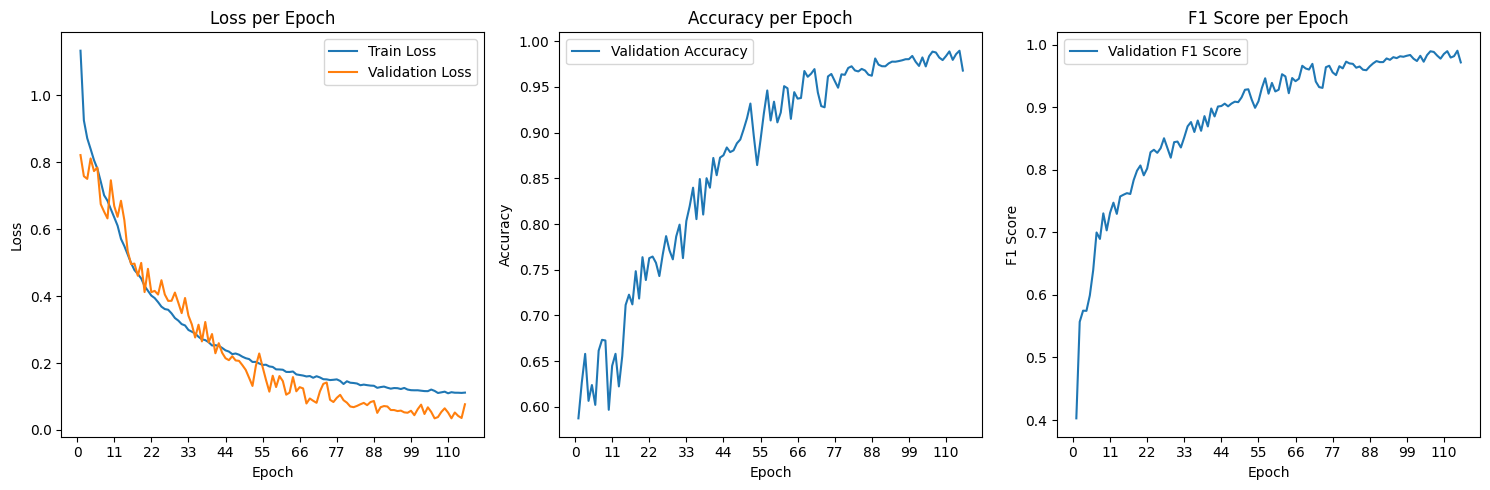

In [8]:
plot('DebuggedModelCheckpoints/BatchNormDropOutCNNModel/interrupted_performance_0_116.json')

# Implementing Adversarial Training with FGSM Attack

In this section, we detail the implementation of a generic adversarial training function, which is designed to enhance the robustness of neural network models against adversarial attacks, specifically through the Fast Gradient Sign Method (FGSM). Adversarial training is a defense mechanism that incorporates adversarially perturbed examples into the training process, aiming to prepare the model to resist potential adversarial exploits.

FGSM is a popular technique for generating adversarial examples, which are slightly modified versions of the original inputs, crafted to deceive the model into making incorrect predictions. These modifications are based on the gradient of the loss with respect to the input data, ensuring the perturbations are in the direction that maximizes the loss, thereby leading the model to misclassify the perturbed image.

During training, the model is exposed to both clean (original) and adversarial examples. This exposure enables the model to learn and adapt to these perturbations, improving its ability to generalize and maintain accuracy even when faced with manipulated inputs.

The adversarial training process iteratively adjusts the model parameters not only to minimize the loss on clean data but also to withstand the adversarial examples. The gradual introduction of adversarial examples, with an increasing level of perturbation (epsilon), allows the model to progressively learn to counter these attacks without compromising its performance on clean data.

By incorporating adversarial training into the model's learning routine, we aim to develop a neural network that is not only accurate in its predictions but also resilient against the manipulative tactics employed in adversarial attacks. This dual focus ensures the trained model is robust and reliable, characteristics essential for practical deployment, especially in critical applications like medical imaging analysis.


In [8]:
def fgsm_attack(model, images, labels, epsilon, criterion):
    """Generates adversarial examples using the Fast Gradient Sign Method (FGSM)."""
    images.requires_grad = True
    outputs = model(images)
    model.zero_grad()
    loss = criterion(outputs, labels)
    loss.backward()
    data_grad = images.grad.data
    perturbed_image = images + epsilon * data_grad.sign()
    perturbed_image = torch.clamp(perturbed_image, 0, 1)  # ensure the perturbed images are still valid
    return perturbed_image


def train_model_with_adversarial(model, train_loader, val_loader, device, model_checkpoint_path, model_name, epochs=5, start_epsilon=0.01, end_epsilon=0.3, load_pretrained=True, last_epoch=0):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())

    # Metrics initialized for multiclass on the correct device
    val_f1_score = torchmetrics.F1Score(num_classes=4, average='macro', task='multiclass').to(device)
    val_accuracy = torchmetrics.Accuracy(num_classes=4, task='multiclass').to(device)

    best_val_loss = float('inf')
    best_val_accuracy = 0
    best_epoch = last_epoch

    train_loss_history = []
    train_accuracy_history = []
    train_f1score_history = []
    val_loss_history = []
    val_accuracy_history = []
    val_f1score_history = []

    model_save_dir = os.path.join(model_checkpoint_path, model_name)
    os.makedirs(model_save_dir, exist_ok=True)

    if load_pretrained and os.path.exists(os.path.join(model_save_dir, f'adv_epoch_{last_epoch}.pth')):
        model.load_state_dict(torch.load(os.path.join(model_save_dir, f'adv_epoch_{last_epoch}.pth'), map_location=device))
        print(f"Loaded pretrained model from {model_save_dir}")

    try:
        for epoch in range(last_epoch, last_epoch + epochs):
            epsilon = start_epsilon + (end_epsilon - start_epsilon) * ((epoch - last_epoch) / epochs)
            model.train()
            total_train_loss = 0

            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()

                # Generate adversarial images
                perturbed_images = fgsm_attack(model, images, labels, epsilon, criterion)

                # Forward pass
                outputs = model(perturbed_images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                total_train_loss += loss.item()

                _, predicted = outputs.max(1)
                val_f1_score.update(predicted, labels)
                val_accuracy.update(predicted, labels)

            avg_train_loss = total_train_loss / len(train_loader)
            train_loss_history.append(avg_train_loss)
            train_accuracy_history.append((predicted == labels).float().mean().item())
            train_f1score_history.append(val_f1_score.compute().item())

            # Validation phase
            model.eval()
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    val_loss = criterion(outputs, labels)

                    val_loss_history.append(val_loss.item())
                    _, predicted = outputs.max(1)
                    val_accuracy.update(predicted, labels)
                    val_f1_score.update(predicted, labels)

                avg_val_loss = torch.tensor(val_loss_history).mean().item()
                val_accuracy_val = val_accuracy.compute().item()
                val_f1score_val = val_f1_score.compute().item()
                val_accuracy_history.append(val_accuracy_val)
                val_f1score_history.append(val_f1score_val)

            print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_train_loss:.4f}, Acc: {val_accuracy_val:.4f}, F1: {val_f1score_val:.4f}')

            # Save the best model based on validation loss
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                save_model_checkpoint(model, model_save_dir, f'best_model_{epoch}.pth')

    except KeyboardInterrupt:
        print("Training interrupted, saving current state...")
        performance_data = {
            'train_loss': train_loss_history,
            'train_accuracy': train_accuracy_history,
            'train_f1score': train_f1score_history,
            'val_loss': val_loss_history,
            'val_accuracy': val_accuracy_history,
            'val_f1score': val_f1score_history
        }
        handle_keyboard_interrupt(model, model_save_dir, performance_data, last_epoch, epoch,adv=True)

    # Final save after training completion
    performance_data = {
        'train_loss': train_loss_history,
        'train_accuracy': train_accuracy_history,
        'train_f1score': train_f1score_history,
        'val_loss': val_loss_history,
        'val_accuracy': val_accuracy_history,
        'val_f1score': val_f1score_history
    }
    save_performance_metrics(performance_data, model_save_dir, 'final_adv_performance_metrics.json')

    return {
        'model_name': model_name,
        'best_epoch': best_epoch,
        'train_loss_history': train_loss_history,
        'train_accuracy_history': train_accuracy_history,
        'train_f1score_history': train_f1score_history,
        'val_loss_history': val_loss_history,
        'val_accuracy_history': val_accuracy_history,
        'val_f1score_history': val_f1score_history
    }


# Evaluation Model Performance (Test)

In [11]:
import os
import torch
from torch import nn
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np  # Import numpy for calculations

def validate(model, model_save_dir, modelName, last_epoch, val_loader, device, num_classes, adv=False):
    model.to(device)
    version = 'Adversarial' if adv else 'Standard'
    model_save_path = os.path.join(f'{model_save_dir}/{modelName}', f'{"adv" if adv else ""}epoch_{last_epoch}.pth')

    if os.path.isfile(model_save_path):
        model.load_state_dict(torch.load(model_save_path, map_location=device))
    else:
        print(f"No pretrained model found at {model_save_path}.")
        return

    criterion = nn.CrossEntropyLoss()
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.view(-1).cpu().numpy())
            all_labels.extend(labels.view(-1).cpu().numpy())

    # Compute the metrics
    val_loss /= len(val_loader)
    val_accuracy = val_correct / val_total
    f1_macro = f1_score(all_labels, all_preds, average='macro')

    # Print the results
    print(f'{version} Model - Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}, F1 Macro: {f1_macro:.4f}')

    # Calculate and normalize the confusion matrix
    cm = confusion_matrix(all_labels, all_preds, labels=list(range(num_classes)))
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize each row to sum to 1

    print('Confusion Matrix:')
    # print(cm_percentage)  # Display the percentage matrix

    # Plot the confusion matrix using seaborn
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_percentage, annot=True, fmt=".2%", cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix for {version} Model')
    plt.show()

    return

Training Set Evaluation:
Standard Model - Loss: 0.0155, Accuracy: 0.9959, F1 Macro: 0.9959
Confusion Matrix:


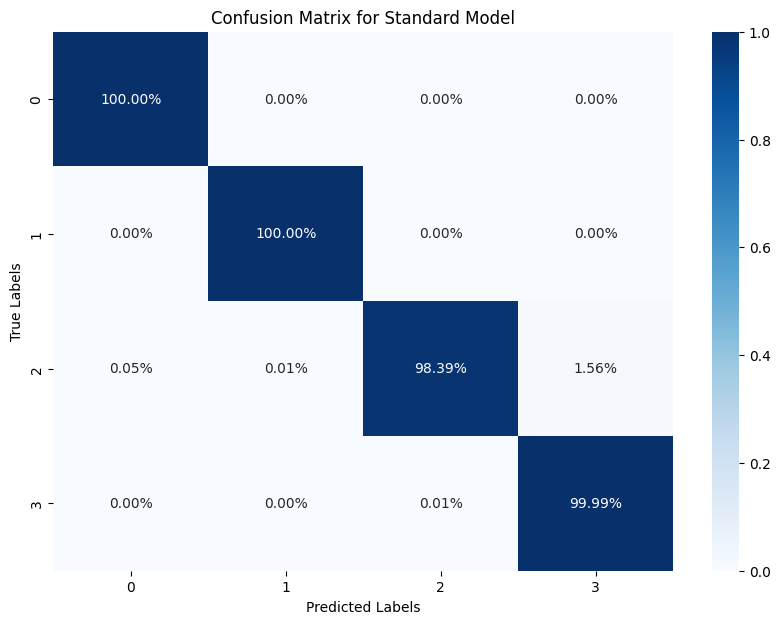

Validation Set Evaluation:
Standard Model - Loss: 0.0356, Accuracy: 0.9897, F1 Macro: 0.9901
Confusion Matrix:


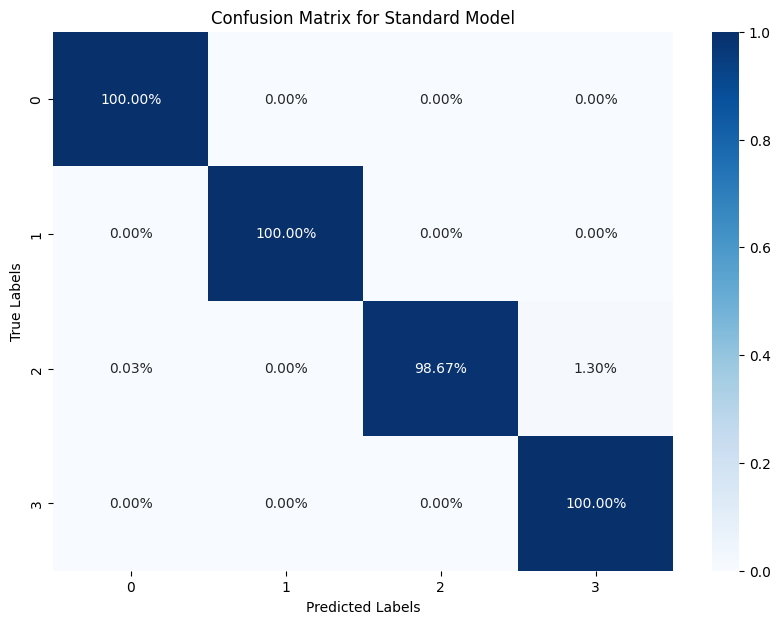

Test Set Evaluation:
Standard Model - Loss: 0.0363, Accuracy: 0.9886, F1 Macro: 0.9888
Confusion Matrix:


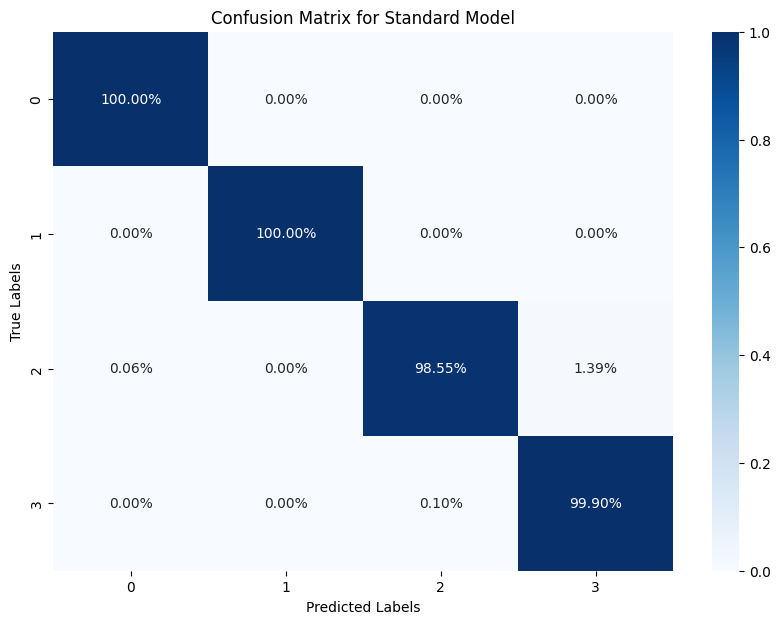

In [13]:
model_checkpoint_path = 'DebuggedModelCheckpoints'
model_name = 'BatchNormDropOutCNNModel'

# Initialize the model
batchNormDropOutCNNModel = BatchNormDropOutCNNModel()
device = torch.device("cuda" if torch.cuda.is_available() else "CPU")

# Validate and print results
print("Training Set Evaluation:")
validate(batchNormDropOutCNNModel, model_checkpoint_path, model_name, 113, train_loader,device,4, adv=False)
print("Validation Set Evaluation:")
validate(batchNormDropOutCNNModel, model_checkpoint_path, model_name, 113, val_loader,device,4, adv=False)
print("Test Set Evaluation:")
validate(batchNormDropOutCNNModel, model_checkpoint_path, model_name,113 , test_loader,device,4, adv=False)

In [15]:
model_checkpoint_path = 'DebuggedModelCheckpoints'
model_name = 'BatchNormDropOutCNNModel'

# Initialize the model
batchNormDropOutCNNModel = BatchNormDropOutCNNModel()
device = torch.device("cuda" if torch.cuda.is_available() else "CPU")

batchNormDropOutCNNModel.load_state_dict(torch.load('DebuggedModelCheckpoints/BatchNormDropOutCNNModel/epoch_113.pth',map_location=torch.device('cpu')))
trainable_params = sum(p.numel() for p in batchNormDropOutCNNModel.parameters() if p.requires_grad)
print(f"Total trainable parameters: {trainable_params}")

Total trainable parameters: 7168100
